In [1]:
import QpixAsicArray as qparray
from QpixAsic import QPByte, ProcQueue
import QpixAsic as qpasic
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(7)

DIRECTIONS = ("North", "East", "South", "West")

In [2]:
# make this a unit test
qpa = qparray.QpixAsicArray(2, 2, debug=0.0, timeout=1e4, deltaT=2e-6)
qpa.Calibrate(0.00025)
print(qpa._daqNode.hitData.items())
end, counts = 0, 0
while True:
    hit = qpa._daqNode._localFifo.Read()
    if hit is None:
        break
    if hit.wordType != qpasic.AsicWord.EVTEND:
        counts += 1
        print(hit, counts)
    else:
        end += 1

print(f"found daq hits: {qpa._daqNode.daqHits}")
print(f"event end: {end}")

dict_items([('(0, 0)', []), ('(0, 1)', []), ('(1, 0)', []), ('(1, 1)', [])])
(0,0): AsicWord.REGRESP  - 5.351485674359715e-06 1
(0,1): AsicWord.REGRESP  - 1.0502873696709451e-05 2
(1,0): AsicWord.REGRESP  - 1.0897923324942458e-05 3
(1,1): AsicWord.REGRESP  - 1.584918178161636e-05 4
(0,0): AsicWord.REGRESP  - 0.0002573556303356563 5
(0,1): AsicWord.REGRESP  - 0.0002624989372988958 6
(1,0): AsicWord.REGRESP  - 0.00026289606616330426 7
(1,1): AsicWord.REGRESP  - 0.00026783665269519675 8
found daq hits: 16
event end: 8


### Inspect ASIC state

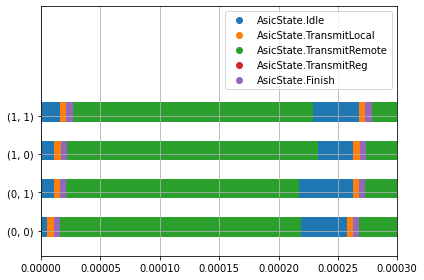

In [3]:
# unit test this based on duration of time out?
qparray.viewAsicState(qpa)

### calculate calibration precision

In [4]:
# investigate why some random seeds allow you to do several calibrations and others dont, maybe it is with the asic oscillation frequency?
row = 2
col = 2

GuessFreqArray = []
PercDiffArray = {}
Keys = []
CalibrateThroughTimes = np.arange(1, 15) * 1e-3
freq = {}

for number, CalTime in enumerate(CalibrateThroughTimes):
    q = qparray.QpixAsicArray(row, col, debug = 0., deltaT = 1e-6, timeEpsilon = 2e-6)
    q.Calibrate(CalTime)

    guessFrq = {}
    for k, v in q._daqNode.regData.items():
        asic = k
        daqTicks = []
        asicTicks = []
        for daqTick, Byte in v:
            daqTicks.append(daqTick)
            asicTicks.append(Byte.data) # Byte[4] or Byte.data depending what is appended
        if len(asicTicks) < 2:
            print(f'\nno work fo da calibration time {CalTime}: ')
            for asic in q:
                print(f'osc freq: {asic.fOsc}')
                print(f'start time {asic._startTime}')
                print()

        # print("asic ticks:", asicTicks)
        guessFrq[asic] = (asicTicks[-1] - asicTicks[-2]) / (daqTicks[-1] - daqTicks[-2])  * q._daqNode.fOsc
        GuessFreqArray.append(guessFrq[asic])
        # print(f'appending {guessFrq[asic]} for asic {asic}')

    for asic in q:
        key = f"({asic.row}, {asic.col})"
        if key not in Keys: Keys.append(key)
        # print(f"{key} percent diff: {(guessFrq[key] - asic.fOsc) / asic.fOsc * 100:1.2E}")
        percdiff = (guessFrq[key] - asic.fOsc) / asic.fOsc * 100
        if key not in PercDiffArray:
            PercDiffArray[key] = []
        PercDiffArray[key].append(percdiff)


Text(0.5, 1.0, 'ASIC Frequency Error Calculation')

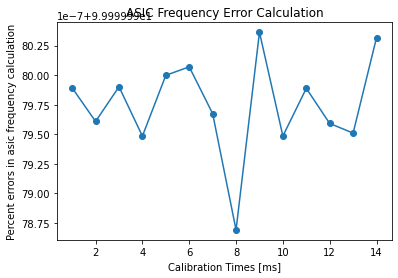

In [5]:
import pylab as p

plot = np.zeros((len(CalibrateThroughTimes)))
for runs in range(len(CalibrateThroughTimes)):
    somethingcreative = []
    for key in Keys:
        somethingcreative.append(np.absolute(PercDiffArray[key][runs]))
    plot[runs] = sum(somethingcreative) / len(Keys);

p.plot(CalibrateThroughTimes * 1e3, plot, linestyle='-', marker='o');
p.xlabel('Calibration Times [ms]')
p.ylabel('Percent errors in asic frequency calculation')
p.title('ASIC Frequency Error Calculation')


### Probe frequencies

In [6]:
bProbeFrq = False
def probeFrequencies():
    ## THIS PROBLEM CAN PROBABLY SOLVED BY MESSING WITH THE TIMEOUT TIME
    CalTimes = np.arange(1, 20) * 1e-3
    WorkingFreq = np.zeros((100000, 4))
    NonWorkingFreq = np.zeros((100000, 4))
    step = 0

    for j in range(1000):
        random.seed(random.randint(0, 100000))
        for i in CalTimes:
            q = qparray.QpixAsicArray(row, col, debug = 0., deltaT = 1e-5, timeEpsilon = 2e-6, timeout=2000)
            q.Interrogate(interval=i)
            if q._alert:
                for index, asic in enumerate(q):
                    NonWorkingFreq[step, index] = asic.fOsc
            else:
                for index, asic in enumerate(q):
                    WorkingFreq[step, index] = asic.fOsc
            step+=1

    WorkingFreq = WorkingFreq[NonWorkingFreq[:,0] == 0]
    WorkingFreq = WorkingFreq[WorkingFreq[:, 0] > 0, 0:3] * 1e-6
    NonWorkingFreq = NonWorkingFreq[NonWorkingFreq[:, 0] > 0, 0:3] * 1e-6
    
    return WorkingFreq, NonWorkingFreq

In [7]:
if bProbeFrq:
    from mpl_toolkits import mplot3d

    WorkingFreq, NonWorkingFreq = probeFrequencies()

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_xlim(43, 58)
    ax.set_xlabel('asic (0, 0) frequency [MHz]')
    ax.set_ylim(43, 58)
    ax.set_ylabel('asic (0, 1) frequency [MHz]')
    ax.set_zlim(43, 58)
    ax.set_zlabel('asic (1, 0) frequency [MHz]')

    ax.plot(*WorkingFreq, marker = 'o', color = 'blue', linestyle = '');
    ax.plot(*NonWorkingFreq, marker = 'o', color = 'red', linestyle = '');
    ax.legend(('working frequency combinations', 'non-working frequency combinations'));
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('red')
    plt.show()

    plt.plot(WorkingFreq[:,0], WorkingFreq[:,1], marker = 'o', color = 'blue', linestyle = '')
    plt.plot(NonWorkingFreq[:,0], NonWorkingFreq[:, 1], marker = 'o', color = 'red', linestyle = '')
    plt.xlabel('asic (0, 0) frequency [MHz]')
    plt.ylabel('asic (0, 1) frequency [MHz]')
    plt.show()


### Test Timeout

In [8]:
def FitFunc(x, a, b):
    """
    fit a straight line
    """
    return a * x + b

In [9]:
bTestTimeout = False
from scipy.optimize import curve_fit as cf
def testTimeout():
    """
    loop through and find if timeouts work or not
    """
    row = 1
    col = 1
    iters = 10
    WorkingTimeoutArray = np.zeros((iters, 2))
    toggle = True
    TimeoutArray = np.arange(1, 1000, 2) * 1e3

    for tiledim in range(iters):

        for timeout in TimeoutArray:
            timeoutwork=0
            array = qparray.QpixAsicArray(row, col, deltaT=1e-4, timeout=timeout, hitsPerSec=30.)
            array.Interrogate(interval=.2)
            for asic in array:
                for direc in range(4):
                    CurSize = asic._remoteFifos[direc]._curSize
                    if CurSize > 0:
                        timeoutwork+=1
            if timeoutwork == 0:
                print(f'timeout {timeout} works for an array of {row} x {col} asics')
                WorkingTimeoutArray[tiledim, 0] = row * col
                WorkingTimeoutArray[tiledim, 1] = timeout
                if toggle:
                    row+=1
                else:
                    col+=1
                toggle = not(toggle)
                break
        if timeout == TimeoutArray[-1]:
            break

    xvalues = WorkingTimeoutArray[:, 0]
    yvalues = WorkingTimeoutArray[:, 1]


    popt, pcov = cf(FitFunc, xvalues, yvalues)

    return popt, pcov, xvalues, yvalues

In [10]:
if bTestTimeout:

    popt, pcov, xvalues, yvalues = testTimeout()
    
    p.plot(xvalues, yvalues, marker='o', linestyle='')
    p.plot(xvalues, FitFunc(xvalues, *popt), linestyle = '--', color = 'red')
    p.title(f'Timeout Required per {array._asics[0][0].randomRate} hits/sec')
    p.xlabel('Number of asics')
    p.ylabel('timeout required to empty all remote fifos [s]')
    txt = f'fit line: y = {popt[0]:2.2f}x + {popt[1]:2.2f}'
    p.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=11);

### Test Route

In [21]:
import time
bTestRoute = False
def testRoute(Sizes):
    FinalSize = max(Sizes)
    LeftRunTimes = np.zeros(FinalSize)
    SnakeRunTimes = np.zeros(FinalSize)
    DynamicRunTimes = np.zeros(FinalSize)
    for route in ['left', 'snake', None]:
        start = time.time()

        moveon = False
        timeout = 15e3

        for ind, size in enumerate(Sizes):
            row = size
            col = size
            numOfAsics = row * col
            array = qparray.QpixAsicArray(row, col, deltaT=1e-5, 
                timeout=timeout)

            ## setup
            ## inject hits into asics
            times = np.arange(0, 5, 0.1)
            for asic in array:
                asic.InjectHits(times=times)
            array.Route(route=route, timeout=timeout)
            ## main
            t = 0
            int_frq = 0.5 # interrogate every second
            stop = 5.5  # 100s of data
            while t < stop:
                array.Interrogate(int_frq)
                t += int_frq

            end = time.time()
            t = end - start
            if route == 'left':
                LeftRunTimes[ind] = t
            elif route == None:
                DynamicRunTimes[ind] = t
            else:
                SnakeRunTimes[ind] = t

    return LeftRunTimes, SnakeRunTimes, DynamicRunTimes

In [22]:
if bTestRoute:
    Sizes = np.arange(1, 5)
    lrt, SnakeRunTimes, DynamicRunTimes = testRoute(Sizes)
    fig, ax = plt.subplots()
    ax.plot(Sizes, lrt, color='blue')
    ax.plot(Sizes, SnakeRunTimes, color='red')
    ax.plot(Sizes, DynamicRunTimes, color='brown')
    ax.set(ylabel='cell run time [s]', xlabel='size of the square asic tile')
    ax.legend(('Left routed run times', 'Snake routed run times', 'Dynamically routed run times'))

### Test Buffers

In [38]:
bTestBuffers = False
def testBuffer(sizes):
    FutileRate_Snake = np.zeros_like(sizes)
    FutileRate_Left = np.zeros_like(sizes)
    FutileRate_Dynamic = np.zeros_like(sizes)

    int_frq = 0.5
    timeout = 1.5e4
    Rates = np.arange(5, 3000, 100)

    for route in [None, 'snake', 'left']:
        for ind, size in enumerate(sizes):
            # why??
            # if route == None:
            #     size+=6
            stobit = False
            row = size
            col = size
            for rate in Rates:
            
                array = qparray.QpixAsicArray(row, col, deltaT=1e-5, 
                    timeout=timeout, hitsPerSec = 1./1.)
                array.Route(route=route, timeout = timeout)

                times = np.linspace(0, int_frq, rate)
                for asic in array:
                    asic.InjectHits(times=times)

                ## main
                array.Interrogate(int_frq)

                for asic in array:
                    key = f'({asic.row}, {asic.col})'
                    for d in range(4):
                        if not(asic._remoteFifos[d]._curSize == 0):
                            print(f'{route}: {key} remote fifo in {DIRECTIONS[d]} had {asic._remoteFifos[d]._curSize} events left in a {size}x{size} tile')
                            stobit = True
                    if not(asic._localFifo._curSize == 0):
                        print(f'{route}: {key} local fifo had {asic._localFifo._curSize} events left in a {size}x{size} tile')
                        stobit = True
                
                if stobit:
                    # print(f'the rate is {rate}')
                    if route == 'snake':
                        FutileRate_Snake[ind] = rate
                    if route == 'left':
                        FutileRate_Left[ind] = rate
                    if route == None:
                        # why??
                        print(f'putting {rate} in the {ind} position of Dynamic')
                        FutileRate_Dynamic[ind] = rate
                    break
                
                if rate == Rates[-1]:
                    if route == 'snake':
                        print(f'{route} routed {size}x{size} asic can take da rate')
                        FutileRate_Snake[ind] = -10
                    if route == 'left':
                        print(f'{route} routed {size}x{size} asic can take da rate')
                        FutileRate_Left[ind] = -10
                    if route == None:
                        print(f'{route} routed {size}x{size} asic can take da rate')
                        FutileRate_Dynamic[ind] = -10
                    break

    return FutileRate_Snake, FutileRate_Left, FutileRate_Dynamic

In [39]:
if bTestBuffers:

    sizes = [8]

    frSnake, frLeft, frDynamic = testBuffer(sizes)

    plt.plot(sizes, frSnake, color = 'red', marker='o')
    plt.plot(sizes, frLeft, color = 'blue', marker='.')
    plt.plot(sizes, frDynamic, color = 'brown', marker='*')
    plt.title(f'Maximum rate of noise at {int_frq}s interrogation and timeout={timeout:2E}')
    plt.xlabel('Size of ASIC tile in nxn')
    plt.ylabel(f'Maximum hits evenly spaced in {int_frq}s')

    plt.legend(('Snake', 'Left', 'Dynamic'))

In [41]:
def testDynamicRoute():
    stobit = False
    size = 7
    for rate in np.arange(1000, 50000, 1000):
        maxTime = 0.5
        array = qparray.QpixAsicArray(size, size, deltaT=1e-5, timeout = 1.5e4)

        print(f'injecting uniform {rate} hits within {maxTime} s.')

        for asic in array:
            times = np.linspace(0, maxTime, rate)
            asic.InjectHits(times=times)

        array.Interrogate(maxTime)

        for asic in array:
            key = f'({asic.row}, {asic.col})'
            # print(f'the reg data and hit data for asic {key} is ', end="")
            # print(len(array._daqNode.regData[key]), end=" and ")
            # print(len(array._daqNode.hitData[key]), end=" \n")
            for d in range(4):
                if not(asic._remoteFifos[d]._curSize == 0):
                    print(f'{key} remote fifo in {DIRECTIONS[d]} had {asic._remoteFifos[d]._curSize} events left in a {size}x{size} tile')
                    print(f'the rate is {rate}')
                    stobit = True
            if not(asic._localFifo._curSize == 0):
                print(f'{key} local fifo had {asic._localFifo._curSize} events left in a {size}x{size} tile')
                print(f'the rate is {rate}')
                stobit = True
        
        if stobit:
            break

In [45]:
def misc():
    Sizes = np.arange(2, 11)
    GoodTiming_Snake = np.zeros_like(Sizes)
    GoodTiming_Left = np.zeros_like(Sizes)
    GoodTiming_Dynamic = np.zeros_like(Sizes)
    int_frq = 0.5
    Timeoutes = np.arange(250, 1e7, 250)
    rate = 12000

    for route in ['snake', 'left', None]:
        for ind, size in enumerate(Sizes):
            row = size
            col = size
            for timeout in Timeoutes:   
                stobit = False
                array = qparray.QpixAsicArray(row, col, deltaT=1e-5, 
                    timeout=timeout, hitsPerSec = 1./1.)
                array.Route(route=route, timeout = timeout)

                #inject the noise in the detectors
                times = np.linspace(0, int_frq, rate)
                channels = [[1, 7, 8]] * len(times)
                for asic in array:
                    asic.InjectHits(times=times, channels=channels)

                ## main
                array.Interrogate(int_frq)
                    # if array._alert:
                        # print('timeout time is too short')

                # qparray.MakeFifoBars(array)
                for asic in array:
                    key = f'({asic.row}, {asic.col})'
                    for d in range(4):
                        if (asic._remoteFifos[d]._curSize == 0):
                            # print(f'{key} remote fifo in {DIRECTIONS[d]} had {asic._remoteFifos[d]._curSize} events left in a {size}x{size} tile')
                            stobit = True
                    if (asic._localFifo._curSize == 0):
                        # print(f'{key} local fifo had {asic._localFifo._curSize} events left in a {size}x{size} tile')
                        # print(f'the asics timeout is {asic._timeout}') 
                        stobit = True
                
                if stobit:
                    if route == 'snake':
                        print(f'putting {timeout} in the {ind} position of {route}')
                        GoodTiming_Snake[ind] = timeout
                    elif route == 'left':
                        print(f'putting {timeout} in the {ind} position of {route}')
                        GoodTiming_Left[ind] = timeout
                    elif route == None:
                        print(f'putting {timeout} in the {ind} position of {route}')
                        GoodTiming_Dynamic[ind] = timeout
                    break
                
                if timeout == Timeoutes[-1]:
                    if route == 'snake':
                        GoodTiming_Snake[ind] = -5
                    elif route == 'left':
                        GoodTiming_Left[ind] = -5
                    elif route == None:
                        GoodTiming_Dynamic[ind] = -5
                    break

    plt.plot(Sizes, GoodTiming_Snake, color = 'red', marker='o')
    plt.plot(Sizes, GoodTiming_Left, color = 'blue', marker='.')
    plt.plot(Sizes, GoodTiming_Dynamic, color = 'brown', marker='*')
    plt.title(f'Minimum timeout time for a {int_frq}s interrogation and rate={rate}')
    plt.xlabel('Size of ASIC tile in nxn')
    plt.ylabel(f'Min timeout time [s]')

    plt.legend(('Snake', 'Left', 'Dynamic'))

In [8]:
def stuff():
    random.seed(7)

    times = [4, 9, 8,2,4,5,1,6]

    pixels = []
    [pixels.append([]) for i in range(len(times))]
    for i in range(len(times)):
        NumOfChan = int(np.absolute(np.ceil(random.gauss(1.5, 2))))
        for channels in range(NumOfChan):
            pixels[i].append(random.randint(0, 16))
    print(f'times is {times}')
    print(f'pixels is {pixels}')

    timesextendo = [0, 1, 2, 3]
    times.extend(timesextendo)
    pixectendo = [[1, 7, 8]] * len(timesextendo)
    pixels.extend(pixectendo)

    times, pixels = zip(*sorted(zip(times, pixels)))
    times = [*times]
    pixels = [*pixels]
    print(times)
    print(pixels)

### Test array with loading json data from radiogenic

In [1]:
# reading in the json file
import codecs, json
outf = "tiledf.json"
obj_text = codecs.open(outf, 'r').read()
readDF = json.loads(obj_text)

In [2]:
import QpixAsicArray as qparray
import numpy as np

rows = readDF["nrows"]
cols = readDF["ncols"]

rad_array = qparray.QpixAsicArray(rows, cols, tiledf=readDF, debug=0)
rad_array.Route(route="left", timeout=15e3)

# radiogenic data lasts until 10 seconds
TIMESTOP = 10
intfrq = 0.5
int_period = np.linspace(0, TIMESTOP, int(TIMESTOP/intfrq))
for i in int_period:
    rad_array.Interrogate(intfrq)

In [3]:
from QpixAsicArray import MakeFifoBars, PrintTransactMap
if False:
    MakeFifoBars(rad_array)

In [4]:
PrintTransactMap(rad_array)

Local Transmissions:
1 7 1 10 1 2 5 3 
1 3 0 6 2 11 7 8 
1 0 2 1 2 2 8 2 
0 0 1 2 0 6 3 2 
3 3 4 1 6 2 1 2 
2 1 3 0 1 1 7 4 
2 0 1 1 2 3 1 3 
4 2 1 0 1 4 1 2 
Remote Transmissions:
1325 142 121 91 70 48 23 0 
1238 154 134 108 86 55 28 0 
1040 137 115 94 72 50 22 0 
863 134 113 91 71 45 22 0 
686 136 112 91 65 43 22 0 
505 136 113 93 72 51 24 0 
326 131 110 89 67 44 23 0 
151 129 108 88 67 43 22 0 
Remote Max Sizes:
192 2 1 2 1 1 1 0 
111 1 1 1 2 7 1 0 
17 1 1 1 1 1 1 0 
17 1 1 1 2 1 1 0 
16 2 1 1 2 1 1 0 
11 1 1 1 2 1 1 0 
4 1 1 1 1 1 1 0 
1 1 1 1 1 1 1 0 
